# Network Anomaly Detection

This notebook runs through an example project for creating an anomaly detection system for network data.

In [1]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import ruptures as rpt
import seaborn as sns
from adtk.data import validate_series
from adtk.detector import LevelShiftAD, PersistAD, SeasonalAD
from adtk.transformer import ClassicSeasonalDecomposition
from plotly.subplots import make_subplots
from pyod.models.iforest import IForest
from utils import anomaly_classification_report, combine_anomalies, cusum_ad, PELTADDetector, plot_anomalies, plot_multivariate_anomalies, plot_network_metrics

warnings.filterwarnings("ignore")


## Data Generation

The network timeseries data is assumed to be telemetry data simplified as aggregated metrics over time: 

`timestamp | bytes_in | bytes_out | error_rate`

The data is aggregated to 5 minute intervals.


In [2]:
def generate_data(
        start='2026-02-01', 
        end='2026-02-02', 
        base_bytes=1000,
        peak_bytes=500,
        peak_hour=21
        ):
    
    # Get timeseries of 5 min timestamps
    ts = pd.date_range(start, end, freq='5min')
    
    # Convert to decimal values within the day
    ts_decimal = ts.hour + (ts.minute / 60) + (ts.second / 3600)

    # Create a cosine cycle to simulate patterns over the day, peaking at the specified hour
    cycle = np.cos(2 * np.pi * (ts_decimal - peak_hour) / 24)

    # Calculate bytes_in and bytes_out with some randomness
    bytes_in = np.maximum(base_bytes + (peak_bytes * cycle) + np.random.normal(0, 100, len(ts)), 0)
    bytes_out = np.maximum((bytes_in / 3) - np.random.normal(0, 50, len(ts)), 0)

    # Add random error rates with a baseline level (and a slight increase during peak hours)
    error_rate = np.minimum(np.maximum(0.05 + (0.01 * cycle) + np.random.normal(0, 0.02, len(ts)), 0), 1)

    # Create a dataframe
    df = pd.DataFrame(index = ts, data={
        'bytes_in': bytes_in,
        'bytes_out': bytes_out,
        'error_rate': error_rate
    })

    return df



In [3]:
df = generate_data('2026-02-02', '2026-02-08')
plot_network_metrics(df, title='Clean network traffic')

### Injecting anomalies

There are some different types of anomalies we may want to detect:
- Point anomalies - suddens spikes or drops
- Level shifts - protracted increases or decreases in the level of the data
- Trend changes - for example from flat to some linear increase

In [4]:
def generate_point_anomalies(df, num_anomalies=10):
    """
    Randomly add spikes or drops in the metrics
    """
    df_anomalous = df.copy()
    anomaly_indices = np.random.choice(df.index, size=num_anomalies, replace=False)

    anomaly_flags = pd.DataFrame(index=df.index, columns=['bytes_in', 'bytes_out', 'error_rate'])
    
    for idx in anomaly_indices:
        # Randomly decide the type of anomaly
        anomaly_type = np.random.choice(['spike', 'drop', 'error_spike'])
        
        if anomaly_type == 'spike':
            df_anomalous.at[idx, 'bytes_in'] *= np.random.uniform(2, 3)  # Spike in bytes_in
            df_anomalous.at[idx, 'bytes_out'] *= np.random.uniform(2, 3)  # Spike in bytes_out
            anomaly_flags.at[idx, 'bytes_in'] = True
            anomaly_flags.at[idx, 'bytes_out'] = True
            
        elif anomaly_type == 'drop':
            df_anomalous.at[idx, 'bytes_in'] *= np.random.uniform(0.1, 0.2)  # Drop in bytes_in
            df_anomalous.at[idx, 'bytes_out'] *= np.random.uniform(0.1, 0.2)  # Drop in bytes_out
            anomaly_flags.at[idx, 'bytes_in'] = True
            anomaly_flags.at[idx, 'bytes_out'] = True
            
        # Note that in reality we might expect spikes and drops in traffic to correlate with spikes in error rates
        elif anomaly_type == 'error_spike':
            df_anomalous.at[idx, 'error_rate'] = min(df_anomalous.at[idx, 'error_rate'] + np.random.uniform(0.1, 0.5), 1)  # Spike in error rate
            anomaly_flags.at[idx, 'error_rate'] = True
    
    return df_anomalous, anomaly_flags.fillna(False)

In [5]:
df_point_anomalies, point_anomaly_indices = generate_point_anomalies(df)
plot_network_metrics(df_point_anomalies, title='Network traffic with point anomalies')

In [6]:
def generate_level_anomalies(df, num_anomalies=1):
    """
    Randomly add sustained periods of increased traffic and error rates.
    The function ensures that level change periods do not overlap.
    Up to `num_anomalies` periods will be added, but this may be reduced if periods overlap and are stripped out.
    """
    df_anomalous = df.copy()
    
    anomaly_flags = pd.DataFrame(index=df.index, columns=['bytes_in', 'bytes_out', 'error_rate'])
    
    # Track which positions are used (including padding)
    used_positions = set()
    padding = 6
    
    for i in range(num_anomalies):    
        # Get available positions throughout the first third of the timeseries (not in used set)
        available_positions = [p for p in range(int(len(df)//3)) if p not in used_positions]
        
        # Stop if not enough positions available
        if len(available_positions) < 6:
            break
        
        # Pick random start from available positions
        start_pos = np.random.choice(available_positions)
        length = np.random.randint(48, 288*2)  # Anomalies lasting between 4 hours and 2 days
        
        # Calculate the actual range that will be marked as used
        end_pos = min(start_pos + length, len(df))
        start_remove = max(0, start_pos - padding)
        end_remove = min(end_pos + padding, len(df))
        
        # Check if this range overlaps with already used positions
        range_to_use = set(range(start_remove, end_remove))
        if range_to_use & used_positions:  # If there's any intersection, skip this anomaly
            continue
        
        level = np.random.uniform(1.2, 1.5)  # Anomaly level (e.g., 1.2x to 1.5x increase)
        
        # Get positional indices for the anomaly period
        anomaly_positions = np.arange(start_pos, end_pos)
        
        # Convert positions to actual index labels for DataFrame operations
        anomaly_indices = df.index[anomaly_positions]
        
        df_anomalous.loc[anomaly_indices, 'bytes_in'] *= level
        df_anomalous.loc[anomaly_indices, 'bytes_out'] *= level
        df_anomalous.loc[anomaly_indices, 'error_rate'] = np.minimum(df_anomalous.loc[anomaly_indices, 'error_rate'] + (level * 0.05), 1)
        
        # Mark the padded range as used
        used_positions.update(range_to_use)
        
        # Mark the start and end of the level change
        anomaly_flags.loc[df.index[start_pos], ['bytes_in', 'bytes_out', 'error_rate']] = True
        anomaly_flags.loc[df.index[np.minimum(end_pos, len(df)-1)], ['bytes_in', 'bytes_out', 'error_rate']] = True
    
    return df_anomalous, anomaly_flags.fillna(False)

In [7]:
df_level_anomalies, level_anomaly_indices = generate_level_anomalies(df)
plot_network_metrics(df_level_anomalies, title='Network traffic with level anomalies')

In [8]:
def generate_trend_anomalies(df):
    """
    Create a change in the underlying trend of the data.

    """

    df_anomalous = df.copy()

    anomaly_flags = pd.DataFrame(index=df.index, columns=['bytes_in', 'bytes_out', 'error_rate'])

    # Allow trend change starts in the second half of the series
    start = np.random.choice(range(len(df)//2, int(len(df)//1.1)))
    length = len(df) - start

    anomaly_indices = df.index[start:start+length]

    m = np.random.uniform(0.01, 0.02) # Random gradient increase of 1 to 2 percentage points per time step

    for i, pos in enumerate(anomaly_indices):
        # df_anomalous.at[pos, 'bytes_in'] *= (1 + (m * i))
        # df_anomalous.at[pos, 'bytes_out'] *= (1 + (m * i))
        df_anomalous.at[pos, 'error_rate'] = np.minimum(df_anomalous.at[pos, 'error_rate'] + ((m * i) * 0.03), 1) # Scaling factor for error_rate increase due to lower base values
        if i == 0:
            anomaly_flags.loc[pos, 'error_rate'] = True

    return df_anomalous, anomaly_flags.fillna(False)



In [9]:
df_trend_anomalies, trend_anomaly_indices = generate_trend_anomalies(df)
plot_network_metrics(df_trend_anomalies, title='Network traffic with trend anomalies')

In [ ]:
# Combine effects of all anomalies and generate separate train and test sets

df_train = generate_data('2026-02-02', '2026-02-08')
df_train, train_point_anomalies = generate_point_anomalies(df_train)
df_train, train_level_anomalies = generate_level_anomalies(df_train)
df_train, train_trend_anomalies = generate_trend_anomalies(df_train)

df_test = generate_data('2026-02-09', '2026-02-15')
df_test, test_point_anomalies = generate_point_anomalies(df_test)
df_test, test_level_anomalies = generate_level_anomalies(df_test)
df_test, test_trend_anomalies = generate_trend_anomalies(df_test)


plot_network_metrics(df_train, title='Training Network Traffic with All Anomalies')


## Anomaly Detection

Anomaly detection can broadly be split into supervised and unsupervised approaches. We may assume that we typically don't have truth labels for anomalies in network data, and so the focus here is on unsupervised approaches.

Some algorithms are trivial to construct by hand (e.g., CUSUM), while others are more conveniently obtained from open source packages:

- [ADTK](https://adtk.readthedocs.io/en/stable/index.html) - Anomaly Detection Toolkit for unsupervised approaches
- [ruptures](https://centre-borelli.github.io/ruptures-docs/) - Changepoint detection in timeseries
- [PyOD](https://pyod.readthedocs.io/en/latest/) - Outlier Detection library


From these packages, we use a suite of approaches to detect each of the anomaly types: 

- Point anomalies - Persist Anomaly Detector, Seasonal Anomaly Detector
- Level anomalies - Level Shift Detector
- Trend anomalies - PELT
- Multivariate anomalies - Isolation Forest


In [11]:
# Check for consistency and absence on duplicates in the timeseries
df_train = validate_series(df_train)

### 1. Persist Anomaly Detector

Runs a rolling window over the timeseries and compares the next point to the median within the window. Flags an anomaly when a threshold is exceeded.

In [12]:
persist_ad = PersistAD(window=5, c=5)
persist_ad_anomalies = persist_ad.fit_detect(df_train).fillna(False)
plot_anomalies(df_train, persist_ad_anomalies, title='Persist AD Test Detector')

### 2. Seasonal Anomaly Detector

Detections anomalous violations of seasonal patterns. 

In [13]:
seasonal_ad = SeasonalAD(c=4, freq=288)  # Assuming daily seasonality with 5-minute intervals (288 intervals per day)
seasonal_anomalies = seasonal_ad.fit_detect(df_train).fillna(False)
plot_anomalies(df_train, seasonal_anomalies, title='Seasonal Anomaly Detector')

### 3. Level Shift Detector

Runs two rolling windows over the data and compares the difference between averages taken within each. Similar to PersistAD but better suited to predict changes in level rather than transient spikes.

In [14]:
levelshift_ad = LevelShiftAD(window=10, c=4)
levelshift_anomalies = levelshift_ad.fit_detect(df_train).fillna(False)
plot_anomalies(df_train, levelshift_anomalies, title='Level Shift Detector')

### 4. PELT: Pruned Exact Linear Time

Algorithm which aims to detect changepoints in timeseries data. Works by segmenting the data with a cost function attempts to keep the data as homogenous as possible in each split. Then scans for changepoints and prunes unlikely candidates.


In [15]:
pelt_ad = PELTADDetector(penalty=20, seasonal_decomposition=True)
pelt_anomalies = pelt_ad.fit_predict(df_train)
plot_anomalies(df_train, pelt_anomalies, title='PELT Trend Change Detection')

### 5. Isolation Forest for multivariate approach

We can consider some anomalies as resulting from a combination of features. In this example, the data is not high-dimensional, but the point and level anomalies are similarly defined across the network metrics. Isolation Forest is therefore trialled as an example of a multivariate approach.

Isolation Forest works by splitting the data across features in a recursive fashion, aiming to separate the data in each split according to a reduction of entropy. This recursive partitioning builds a tree structure. Anomalies typically have significantly shorter paths to terminating nodes, and so can be detected on that basis after the trees have been created and ensembled.

In [16]:
clf = IForest(contamination=0.01)
iforest_anomalies = clf.fit_predict(df_train)
iforest_anomalies = pd.Series(iforest_anomalies, index=df_train.index).astype(bool)
plot_multivariate_anomalies(df_train, iforest_anomalies, title='Multivariate Anomalies Detected by Isolation Forest')

### Combined Anomaly Detectors

Here we combine together the detectors which seem most appropriate for our data (i.e., excluding the multivariate approach)

In [22]:
pred_combined_anomalies = combine_anomalies([persist_ad_anomalies, seasonal_anomalies, levelshift_anomalies, pelt_anomalies])

actual_combined_anomalies = combine_anomalies([
    train_point_anomalies,
    train_level_anomalies,
    train_trend_anomalies
])

plot_anomalies(df_train, pred_combined_anomalies, actual_combined_anomalies, title='TRAINING Combined Anomaly Detectors (green=actual, red=predicted)')


## Evaluation of Detection Performance

The detectors should be run on unseen test data for a fair view of how the approach might generalise.

Make use of classification metrics and confusion matrices to evaluate the detector performance.

The selection of performance measure can depend on the domain requirements:
- High recall is required when there are large costs associated with missing an anomaly (i.e., system failure)
- High precision is important when false positives are expensive (i.e., due to alert fatigue or wasted engineer cost)
- F1 score is good to consider if we're happy balancing precision and recall (or use Fbeta scores if different weightings are required)

In [26]:
# Run the suite of anomaly detectors on the test set

test_persist_ad_anomalies = persist_ad.detect(df_test).fillna(False)
test_seasonal_ad_anomalies = seasonal_ad.detect(df_test).fillna(False)
test_level_anomalies = levelshift_ad.detect(df_test).fillna(False)
test_pelt_anomalies = pelt_ad.predict(df_test)


In [27]:
# Combine test anomalies and plot against actual anomalies
test_pred_combined_anomalies = combine_anomalies([test_persist_ad_anomalies, test_seasonal_ad_anomalies, test_level_anomalies, test_pelt_anomalies])

test_actual_combined_anomalies = combine_anomalies([
    test_point_anomalies,
    test_level_anomalies,
    test_trend_anomalies
])

plot_anomalies(df_test, test_pred_combined_anomalies, test_actual_combined_anomalies, title='TESTING Combined Anomaly Detectors (green=actual, red=predicted)')

Classification Report for bytes_in Anomalies:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1718
        True       0.71      0.91      0.80        11

    accuracy                           1.00      1729
   macro avg       0.86      0.95      0.90      1729
weighted avg       1.00      1.00      1.00      1729



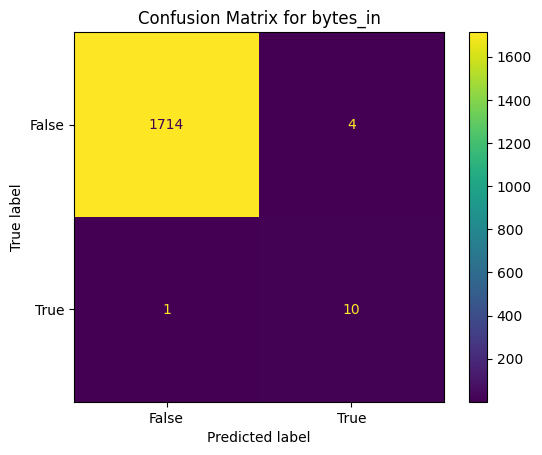

---------------------------------------------------------------------------

Classification Report for bytes_out Anomalies:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1721
        True       0.64      0.88      0.74         8

    accuracy                           1.00      1729
   macro avg       0.82      0.94      0.87      1729
weighted avg       1.00      1.00      1.00      1729



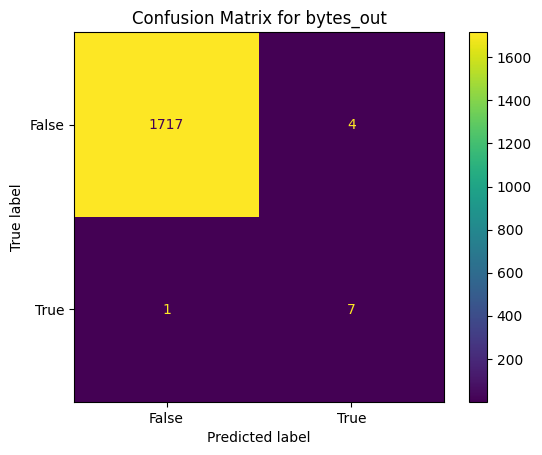

---------------------------------------------------------------------------

Classification Report for error_rate Anomalies:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1709
        True       0.95      0.95      0.95        20

    accuracy                           1.00      1729
   macro avg       0.97      0.97      0.97      1729
weighted avg       1.00      1.00      1.00      1729



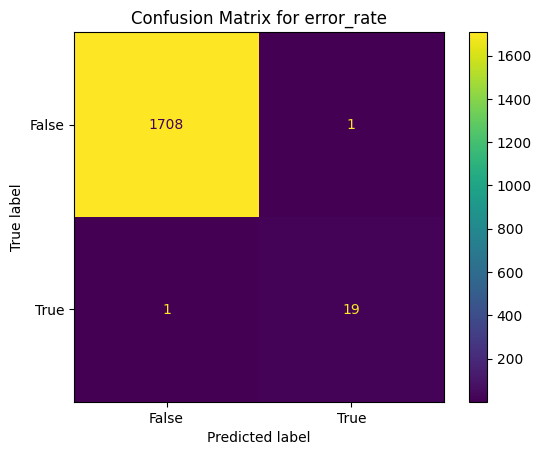

---------------------------------------------------------------------------



In [28]:
# Exact timing classification performance
anomaly_classification_report(test_actual_combined_anomalies, test_pred_combined_anomalies)

### Performance over aggregated timings

Consider that the exact timing of the anomaly starting may be less relevant than being able to detect the anomaly in the first place. Consider aggregating or smoothing the anomaly timeseries to demonstrate typical detection rates regardless of exact timing.

Classification Report for bytes_in Anomalies:
              precision    recall  f1-score   support

       False       0.99      0.98      0.99       136
        True       0.73      0.89      0.80         9

    accuracy                           0.97       145
   macro avg       0.86      0.93      0.89       145
weighted avg       0.98      0.97      0.97       145



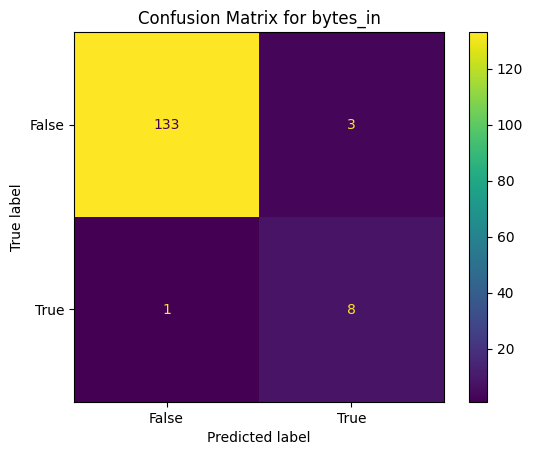

---------------------------------------------------------------------------

Classification Report for bytes_out Anomalies:
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       137
        True       0.64      0.88      0.74         8

    accuracy                           0.97       145
   macro avg       0.81      0.92      0.86       145
weighted avg       0.97      0.97      0.97       145



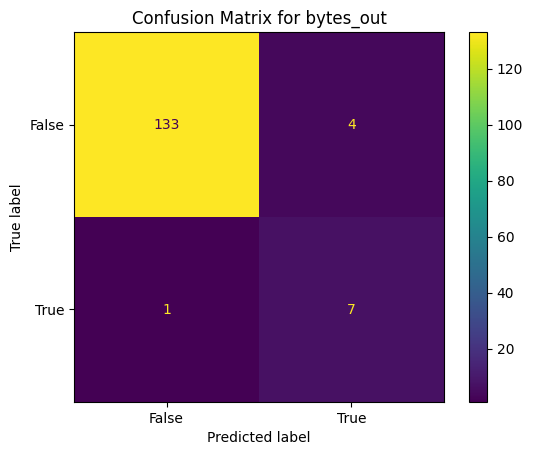

---------------------------------------------------------------------------

Classification Report for error_rate Anomalies:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       139
        True       0.83      0.83      0.83         6

    accuracy                           0.99       145
   macro avg       0.91      0.91      0.91       145
weighted avg       0.99      0.99      0.99       145



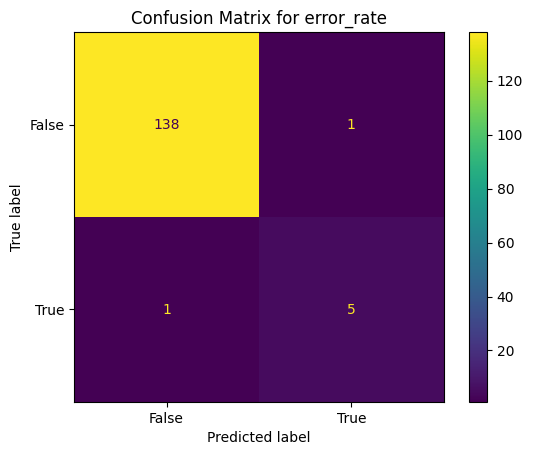

---------------------------------------------------------------------------



In [29]:
# Aggregated timing classification performance

test_actual_combined_anomalies_hourly = test_actual_combined_anomalies.astype(int).resample('1H').max().astype(bool)
test_pred_combined_anomalies_hourly = test_pred_combined_anomalies.astype(int).resample('1H').max().astype(bool)

plot_anomalies(df_test.resample('1H').min(), test_pred_combined_anomalies_hourly, test_actual_combined_anomalies_hourly, title='Hourly Combined Anomalies (green=actual, red=predicted)')

anomaly_classification_report(test_actual_combined_anomalies_hourly, test_pred_combined_anomalies_hourly)


## Wrap up

This notebook has demonstrated the use of a suite of unsupervised anomaly detection algorithms for finding faults in network timeseries data.

The approach taken was to consider that there are different flavours of anomaly which may appear in timeseries data. Specific algorithms were selected to help identify each type of anomaly type. 

By combining results from different detectors we can acheive good performance on unseen test data.